# Clustering time trends for New York City businesses

In [330]:
import pandas as pd
import geopandas as gp
import numpy as np
import zipfile
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, DBSCAN
import matplotlib as plt
import matplotlib.cm as cm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [331]:
#Downloading zipcode data
zipcode_shape = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
zipcode_shape.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [332]:
zipcode_shape.columns

Index([           u'@id', u'BLDGpostalCode',       u'CTY_FIPS',
             u'OBJECTID',        u'PO_NAME',          u'STATE',
              u'ST_FIPS',     u'Shape_Area',     u'Shape_Leng',
              u'borough',       u'geometry',     u'postalCode'],
      dtype='object')

In [333]:
#Dropping extraneous columns and renaming 'postalcode' to 'zip'
zipcode_shape = zipcode_shape.drop([  u'@id', u'BLDGpostalCode',       u'CTY_FIPS', u'ST_FIPS',
             u'OBJECTID', u'Shape_Area',     u'Shape_Leng'], axis = 1)
zipcode_shape = zipcode_shape.rename(columns={'postalCode' : 'zip'})
zipcode_shape.head()

,PO_NAME,STATE,borough,geometry,zip
0,Jackson Heights,NY,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,Glen Oaks,NY,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,New Hyde Park,NY,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,Bellerose,NY,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,Fresh Meadows,NY,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [334]:
#Converting zip column to numeric datatype
zipcode_shape['zip'] = pd.to_numeric(zipcode_shape['zip'])

In [335]:
#Creating a list of years from 1994 - 2015
year = []
for i in range(94, 100, 1):
    year.append(str(i))
for i in range(0, 10, 1):
    year.append('0'+str(i))
for i in range(10, 15, 1):
    year.append(str(i))

In [336]:
#Reading datafiles
for i in year:
    zf = zipfile.ZipFile('zbp'+i+'totals.zip')
    business_data = pd.read_csv(zf.open('zbp'+i+'totals.zip'.replace('.zip','.txt')))
    print("Year "+str(i)+'\n')
    print(business_data.head(2))
    print('\n')

Year 94

    zip         name empflag   emp    qp1      ap  est
0  1001   Agawam, MA     NaN  6198  33601  155158  439
1  1002  Amherst, MA     NaN  6073  28924  127367  450


Year 95

    zip             name empflag  emp  qp1    ap  est
0   501   Holtsville, NY       B    0    0     0    2
1  1000  Springfield, MA     NaN   49  529  2127    4


Year 96

    zip             name empflag  emp   qp1    ap  est
0   501   Holtsville, NY       B    0     0     0    4
1  1000  Springfield, MA     NaN  161  1494  6671   11


Year 97

    zip             name empflag  emp  qp1   ap  est
0   501   HOLTSVILLE, NY     NaN   47  168  523    4
1  1000  SPRINGFIELD, MA       E    0    0    0    8


Year 98

    ZIP            NAME EMPFLAG   EMP    QP1      AP  EST
0   501  HOLTSVILLE, NY     NaN     2     11      57    3
1  1001      AGAWAM, MA     NaN  7121  47926  215641  444


Year 99

    ZIP            NAME EMPFLAG   EMP    QP1      AP  EST
0   501  HOLTSVILLE, NY       B     0      0       0 

In [337]:
#Adding data to the zipcode_shape table
for i in year:
    zf = zipfile.ZipFile('zbp'+i+'totals.zip')
    temp = pd.read_csv(zf.open('zbp'+i+'totals.zip'.replace('.zip','.txt')))
    temp.columns = map(str.lower, temp.columns)
    temp = temp[['zip', 'est']]
    temp.rename(columns={'est' : 'est'+str(i)}, inplace=True)
    zipcode_shape = zipcode_shape.merge(temp, on = 'zip', how = 'inner')

### From the census data, I need only the 'zip' and 'est' columns for my analysis. In order to convert my columns into a standard format, I converted each column to lowercase. After getting the columns into the standard format, I merged them to get yearly data of the businesses.

In [338]:
#Checking shape of zipcode_shape c
zipcode_shape.shape

(243, 26)

In [339]:
zipcode_shape.columns

Index([ u'PO_NAME',    u'STATE',  u'borough', u'geometry',      u'zip',
          u'est94',    u'est95',    u'est96',    u'est97',    u'est98',
          u'est99',    u'est00',    u'est01',    u'est02',    u'est03',
          u'est04',    u'est05',    u'est06',    u'est07',    u'est08',
          u'est09',    u'est10',    u'est11',    u'est12',    u'est13',
          u'est14'],
      dtype='object')

In [340]:
zipcode_shape.head()

,PO_NAME,STATE,borough,geometry,zip,est94,est95,est96,est97,est98,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,Jackson Heights,NY,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1229,1236,1292,1309,1351,...,1539,1527,1545,1538,1572,1629,1647,1724,1759,1768
1,Glen Oaks,NY,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,194,188,176,192,194,...,225,226,238,227,233,229,222,241,241,250
2,New Hyde Park,NY,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1422,1414,1335,1344,1344,...,1441,1454,1488,1503,1475,1494,1488,1510,1539,1534
3,Bellerose,NY,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,326,219,209,198,203,...,226,226,228,226,237,248,256,266,258,260
4,Fresh Meadows,NY,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,492,476,483,522,509,...,604,608,617,616,628,643,677,679,714,731


In [341]:
#Whitening the data
est_mean = zipcode_shape.iloc[:,range(5,26)].mean(axis = 1)
est_std = zipcode_shape.iloc[:,range(5,26)].std(axis = 1)
zipcode_shape.iloc[:,range(5,26)] = zipcode_shape.iloc[:,range(4,26)].apply(lambda x: (x- est_mean) / est_std)
zipcode_shape.head()

,PO_NAME,STATE,borough,geometry,zip,est94,est95,est96,est97,est98,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,Jackson Heights,NY,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,Glen Oaks,NY,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923
2,New Hyde Park,NY,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,...,0.157401,0.345867,0.838780,1.056241,0.650313,0.925765,0.838780,1.157723,1.578149,1.505662
3,Bellerose,NY,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,3.212291,-0.444253,-0.785986,-1.161892,-0.991026,...,-0.205040,-0.205040,-0.136693,-0.205040,0.170867,0.546773,0.820159,1.161892,0.888506,0.956853
4,Fresh Meadows,NY,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,-1.332578,-1.549090,-1.454366,-0.926619,-1.102534,...,0.183004,0.237132,0.358920,0.345388,0.507772,0.710751,1.170839,1.197903,1.671522,1.901566


### I have whitened the dataset. This has been done to decorrelate the each column of the dataset.

In [342]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

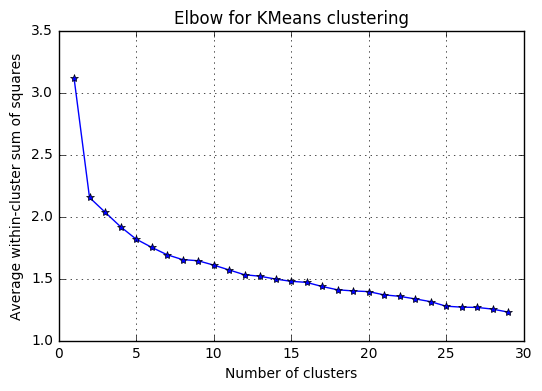

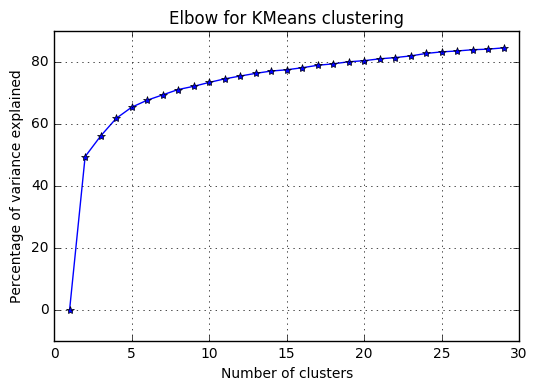

In [343]:
elbow(zipcode_shape.iloc[:, range(5,26)], range(1,30))

### From the elbow method, we can see elbow at Number of clusters = 2. Hence, we can select k = 2

In [344]:
#Checking silhouette score
X=zipcode_shape.iloc[:, range(5,26)]
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.572142801777
For n_clusters =3, the average silhouette_score is :0.541435020202
For n_clusters =4, the average silhouette_score is :0.495601550463
For n_clusters =5, the average silhouette_score is :0.478801351965
For n_clusters =6, the average silhouette_score is :0.234252779225
For n_clusters =7, the average silhouette_score is :0.269653212641
For n_clusters =8, the average silhouette_score is :0.1408578891
For n_clusters =9, the average silhouette_score is :0.20686549319


### Using silhouette score, it is evident that number of clusters = 2. Hence, I am choosing number of clusters = 2

In [345]:
#KMeans cluster
kmeans_cluster = KMeans(2).fit(zipcode_shape.iloc[:, range(5,26)])
centers = kmeans_cluster.cluster_centers_
zipcode_shape['km_labels'] = kmeans_cluster.labels_

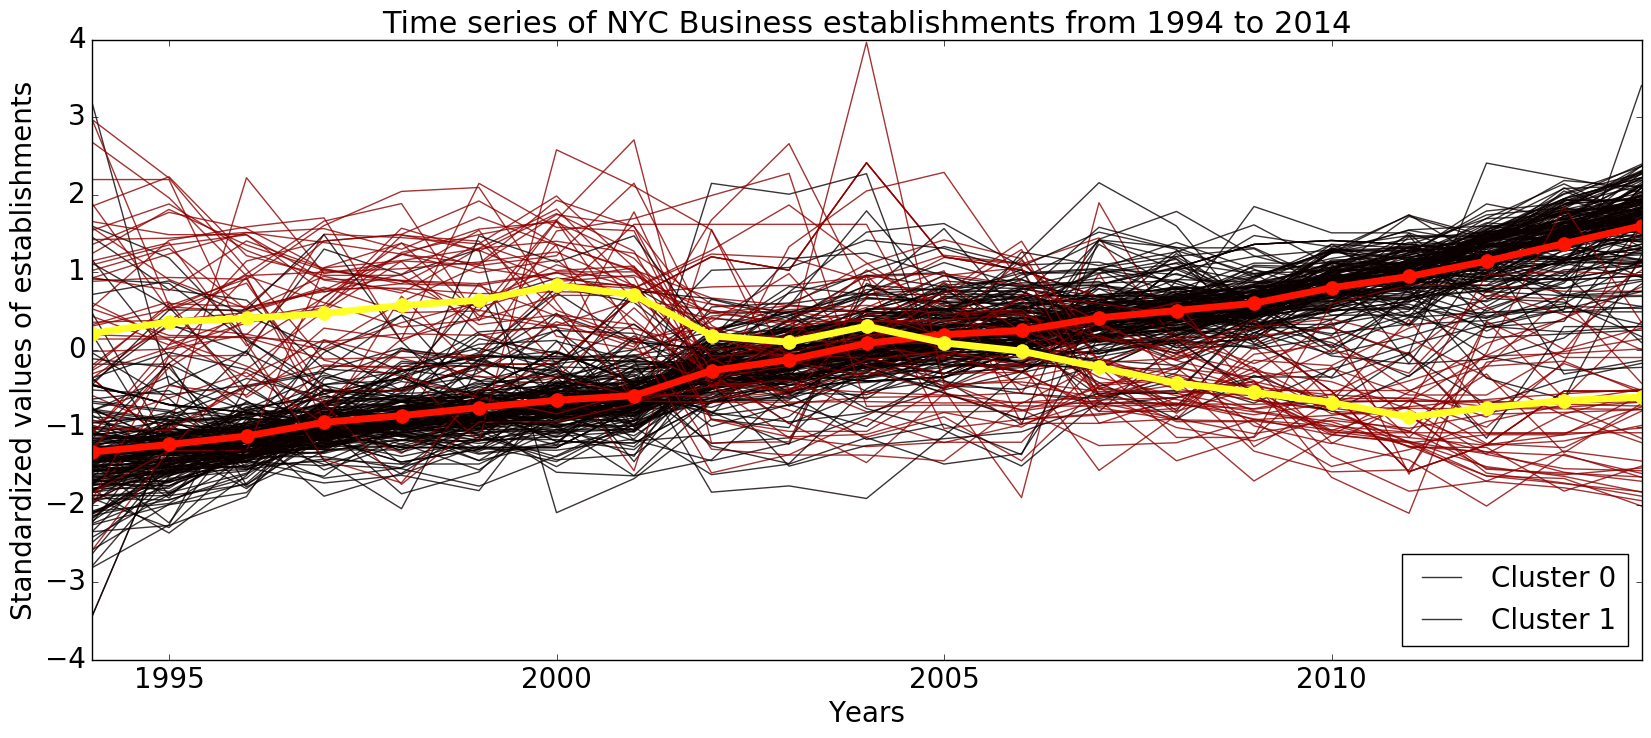

In [373]:
#Plotting timeseries of 
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
for i in range(len(zipcode_shape)):
    ax.plot(range(1994,2015), zipcode_shape.iloc[i,range(5,26)], 
            '-', lw = 1, alpha = 0.8, c=cm.hot(zipcode_shape.km_labels[i]*50) )
plt.xlim(1994,2014)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Years", fontsize=20)
plt.ylabel("Standardized values of establishments", fontsize=20)
plt.title('Time series of NYC Business establishments from 1994 to 2014', 
          fontsize=22)
for i in range(len(centers)):
    plt.plot(range(1994,2015),centers[i], 
              '.-', ms = 20, lw = 5, c=cm.hot((i+1)*100))
plt.legend(['Cluster 0', 'Cluster 1'], loc = 'best', fontsize=20)
plt.show()

### Figure 1: Time series of number of business establishments in different zipcodes in NYC from 1994 to 2014. The time series of the zipcodes is standarized and clustered into 2 groups. The red line indicates an increase in business establishments over the years and the yellow line indicates a downward trend.

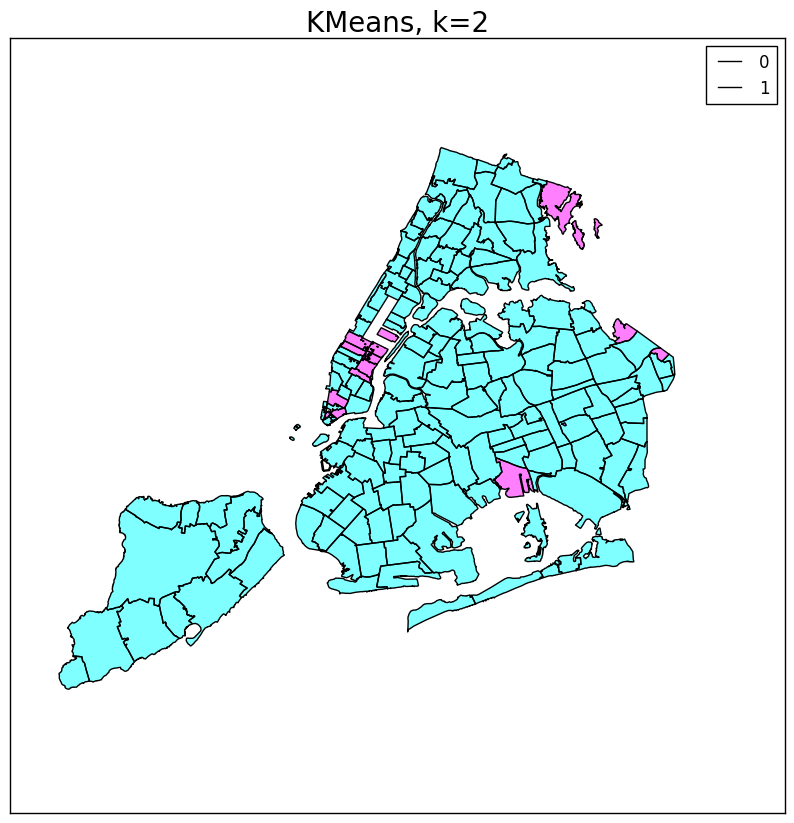

In [378]:
#Plotting KMeans cluster spatially
f, ax = plt.subplots(figsize=(10,10))
zipcode_shape.plot(colormap='cool', column='km_labels', ax = ax)
ax.set_title("KMeans, k=2", fontsize=20)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend(zipcode_shape.km_labels.unique())

### Figure 2: Clusters of business establishment in New York City using KMeans. A majority of the areas are clustered as cyan which in the timeseries is the upward trending timeseries cluster. This might be caused by an array of factors such as ease of doing business in the city to a drop in crime rate in New York City during that period.

In [362]:
#DBSCAN
dbscan_cluster = DBSCAN(2).fit(zipcode_shape.iloc[:,range(5,26)])
zipcode_shape['dbscan_labels'] = dbscan_cluster.labels_

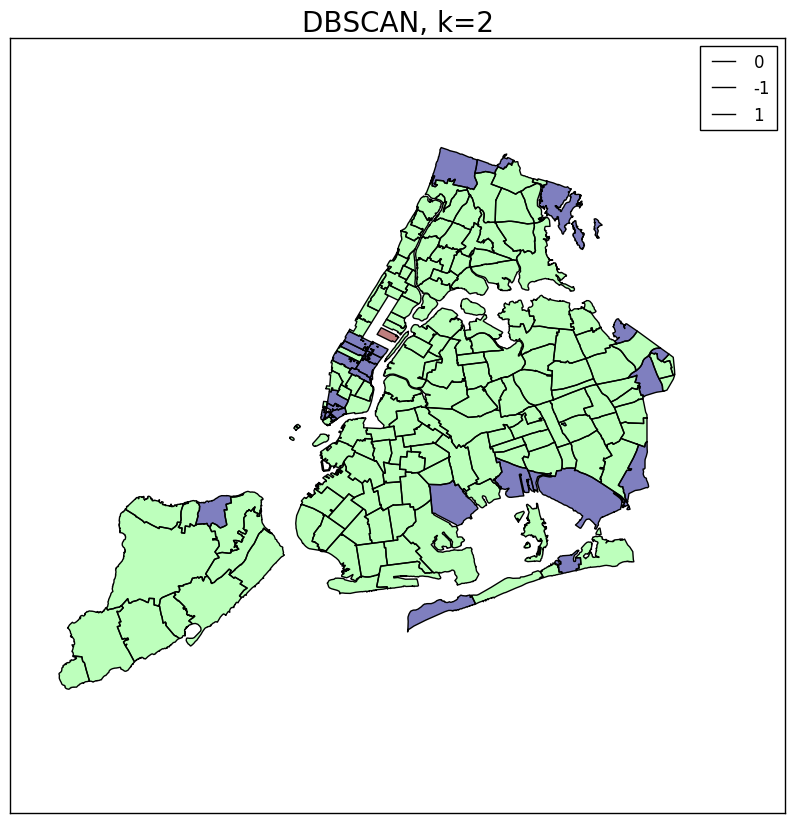

In [380]:
#Plotting DBSCAN cluster spatially
f, ax = plt.subplots(figsize=(10,10))
zipcode_shape.plot(colormap='jet', column='dbscan_labels', ax=ax)
ax.set_title("DBSCAN, k=2", fontsize=20)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend(zipcode_shape.dbscan_labels.unique())

### Figure 3: Clusters of business establishment in New York City using DBSCAN. DBSCAN is a better method to interpret spatial data and hence in this case is superior to KMeans clustering. As observed in the map, we can see, a majority of zipcodes in New York City have increased number of business establishments as evident by the red line in the timeseries plot. The other zipcodes do not have a specific trend in the data which can be infered as no significant change (small downward trend globally) in business establishments. This might be caused in the Lower Manhattan and Midtown Manhattan due to saturation of number of business establishments and in other zipcodes perhaps due to lack of incentives for business development. THe cluster indicated by '-1' is an outlier.